In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Concatenate, Reshape, Input, Conv1D, Flatten, MaxPooling1D
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1980-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  480 non-null    float64
 1   ip         480 non-null    float64
dtypes: float64(2)
memory usage: 11.2 KB


In [7]:
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,46.0471
1980-02-01,66.9,47.1305
1980-03-01,56.5,47.6433
1980-04-01,52.7,46.2537
1980-05-01,51.7,44.9161


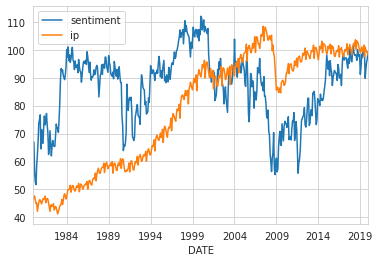

In [8]:
# 이 2개의 시계열을 한번에 모델링 해서
# 2개의 시계열을 각각 예측
df.plot()

Stationarity

In [9]:
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
                                'sentiment': df.sentiment.diff(12)})
                  .dropna())

Scaling

In [10]:
df_transformed = df_transformed.apply(minmax_scale)

변환과정 수행 후에도 데이터가 비정상
=> RNN에 데이터를 넣어도 모델링이 안됨
=> RNN은 앞 뒤 관계를 통해서 미래를 맞춤.
=> RNN을 쓰기 위해서는 앞 뒤 관계가 명확한 데이터를 넣어주어야 한다.

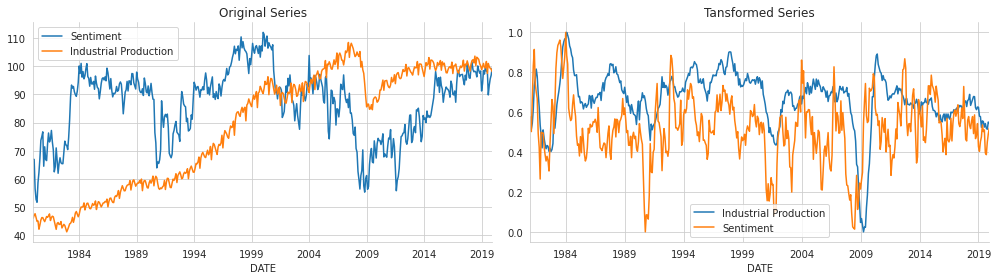

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
columns={'ip': 'Industrial Production', 'sentiment': 'Sentiment'}
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Tansformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)

In [12]:
from numpy import array
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [13]:
window_size = 20
n_step_out = 6

In [14]:
X, y = split_sequence(df_transformed, window_size, n_step_out)

In [15]:
X.shape, y.shape

((443, 20, 2), (443, 6, 2))

In [16]:
test_size = 24
train_size = X.shape[0]-test_size

In [17]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [18]:
X_test

array([[[0.55111661, 0.48576214],
        [0.58191998, 0.40033501],
        [0.59112016, 0.44053601],
        [0.55643056, 0.46901173],
        [0.5910033 , 0.38693467],
        [0.56733137, 0.56951424],
        [0.59086607, 0.45896147],
        [0.5714395 , 0.45058626],
        [0.5646568 , 0.46733668],
        [0.60022792, 0.56951424],
        [0.59806401, 0.45561139],
        [0.59802122, 0.54438861],
        [0.61246204, 0.59631491],
        [0.60452417, 0.61139028],
        [0.61384603, 0.57956449],
        [0.6208421 , 0.60134003],
        [0.59730404, 0.63651591],
        [0.63442978, 0.54271357],
        [0.62699183, 0.52763819],
        [0.63333687, 0.55946399]],

       [[0.58191998, 0.40033501],
        [0.59112016, 0.44053601],
        [0.55643056, 0.46901173],
        [0.5910033 , 0.38693467],
        [0.56733137, 0.56951424],
        [0.59086607, 0.45896147],
        [0.5714395 , 0.45058626],
        [0.5646568 , 0.46733668],
        [0.60022792, 0.56951424],
        [0.5

In [19]:
X_train.shape, X_test.shape

((419, 20, 2), (24, 20, 2))

In [20]:
K.clear_session()

In [21]:
n_features = output_size = 2

In [22]:
lstm_units = 200
dense_units = 128

In [23]:
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features),
         return_sequences=True),
      LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=False),
    RepeatVector(n_step_out),
      LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=True),
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=True),
    TimeDistributed(Dense(dense_units)),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(Dense(dense_units)),
    TimeDistributed(Dense(output_size))
])

In [ ]:
rnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu',
	          input_shape=(window_size, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    RepeatVector(n_step_out),
      LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=True),
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
        #  input_shape=(window_size, n_features),
         return_sequences=True),
    TimeDistributed(Dense(dense_units)),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(Dense(dense_units)),
    TimeDistributed(Dense(output_size))
])

In [24]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 200)           162400    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 repeat_vector (RepeatVector  (None, 6, 200)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 6, 200)            320800    
                                                                 
 lstm_3 (LSTM)               (None, 6, 200)            320800    
                                                                 
 time_distributed (TimeDistr  (None, 6, 128)           25728     
 ibuted)                                                

In [25]:
rnn.compile(loss='mse', optimizer='RMSProp')

In [26]:
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [28]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.1209
Epoch 1: val_loss improved from inf to 0.00937, saving model to results/multivariate_time_series/lstm.h5
21/21 [==============================] - 18s 255ms/step - loss: 0.1209 - val_loss: 0.0094
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.0337
Epoch 2: val_loss improved from 0.00937 to 0.00583, saving model to results/multivariate_time_series/lstm.h5
21/21 [==============================] - 5s 218ms/step - loss: 0.0337 - val_loss: 0.0058
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.0309
Epoch 3: val_loss improved from 0.00583 to 0.00525, saving model to results/multivariate_time_series/lstm.h5
21/21 [==============================] - 4s 214ms/step - loss: 0.0309 - val_loss: 0.0053
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 0.0300
Epoch 4: val_loss improved from 0.00525 to 0.00449, saving model to results/multivariate_time_series/lstm

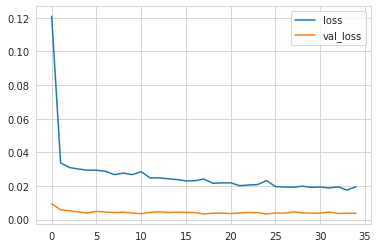

In [29]:
pd.DataFrame(result.history).plot()

In [30]:
pred = rnn.predict(X_test)

In [31]:
pred.shape

(24, 6, 2)

In [ ]:
# y_pred = pd.DataFrame(rnn.predict(X_test), 
#                       columns=['sentiment', 'ip'])
# y_pred.info()

ValueError: ignored

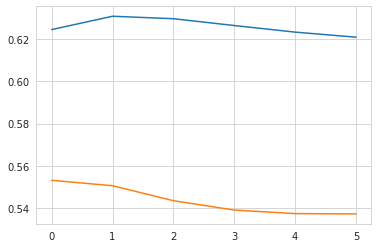

In [34]:
plt.plot(pred[1])

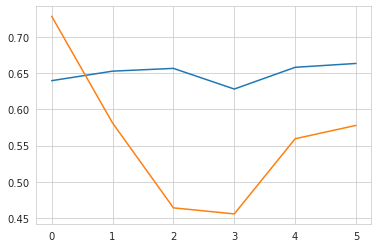

In [35]:
plt.plot(y_test[2])

In [36]:
test_mae_loss = np.mean(np.abs(pred - y_test), axis=1)

In [37]:
test_mae_loss

array([[0.01584228, 0.07762318],
       [0.01942275, 0.06822241],
       [0.02490075, 0.07235689],
       [0.03041236, 0.04517609],
       [0.02659242, 0.04742047],
       [0.02718046, 0.03102067],
       [0.04018198, 0.02800366],
       [0.04672252, 0.0290584 ],
       [0.04913379, 0.03345645],
       [0.03790318, 0.04090613],
       [0.03527553, 0.04214566],
       [0.03124268, 0.04226974],
       [0.02429675, 0.05454442],
       [0.02013701, 0.067404  ],
       [0.01634849, 0.0765427 ],
       [0.02909919, 0.06929269],
       [0.03780884, 0.05972433],
       [0.04688849, 0.06411697],
       [0.05631972, 0.04565784],
       [0.0570538 , 0.04198062],
       [0.06340567, 0.05040475],
       [0.06384382, 0.05245293],
       [0.06834043, 0.06353859],
       [0.07366275, 0.07105464]])